In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

import warnings
warnings.filterwarnings('ignore')

# Data Collection

In [ ]:
train = pd.read_excel(r'C:\Users\Shubham\Desktop\Projects\Evaluation\(7)_Flight\Flight_Ticket_Participant_Datasets\Data_Train1.xlsx')

In [ ]:
test = pd.read_excel(r'C:\Users\Shubham\Desktop\Projects\Evaluation\(7)_Flight\Flight_Ticket_Participant_Datasets\Test_set1.xlsx')

# Data Understanding

In [ ]:
pd.set_option("display.max_columns", None)
train.head() #Looking into the top 5 rows of the train dataset

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
test.head() #Looking into the top 5 rows of test the dataset

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


The only column missing in the test dataframe is the price column, i.e, the target variable.

In [ ]:
train.columns #Calling all the column names of the dataset

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [ ]:
train.info() #Basic info of the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


We see most of the data is object type and only the dependant variable to be numerical data.

In [ ]:
train.shape #Looking into the shape of the dataset

(10683, 11)

In [ ]:
train.isnull().sum() #Checking for null values again

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

We see there is only 2 null values, one in route and total_stops each. Since we have more than 10000 rows of data, we shall drop the rows with null values.

In [ ]:
train.dropna(inplace=True) #Dropping the rows with null values

In [ ]:
train.shape #Checking the shape of the dataset

(10682, 11)

<AxesSubplot:>

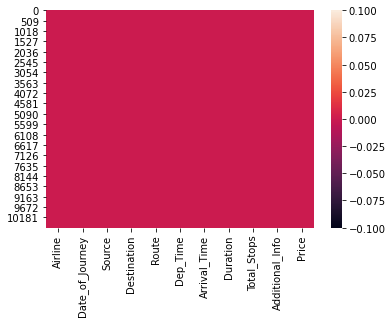

In [ ]:
sns.heatmap(train.isnull()) #Visualization of null values

This shows that there are no null values present

# Exploratory Data Analysis

Let us now look into all the columns one at a time, beginning with the target column price

<AxesSubplot:xlabel='Price', ylabel='Density'>

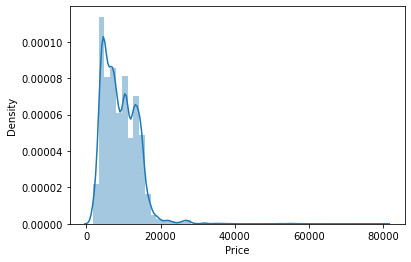

In [ ]:
#Density plot for the Price
sns.distplot(train['Price'])

<AxesSubplot:xlabel='Price'>

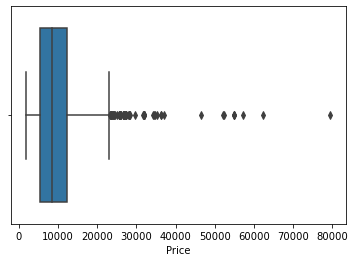

In [ ]:
#Box plot for the Price
sns.boxplot(train['Price'])

Next column we look for is 'Airline'

In [ ]:
#Checking for unique values
train['Airline'].unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

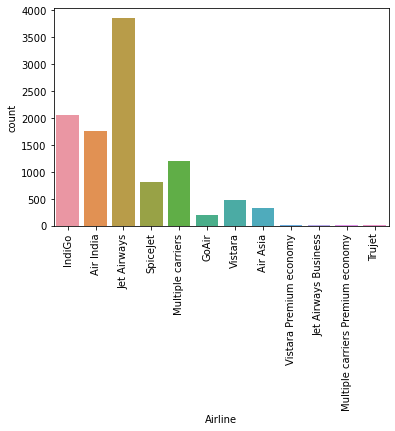

In [ ]:
#Count plot for the Airline
sns.countplot(train['Airline'])
plt.xticks(rotation=90)
plt.show()

We see that Jet Airways is the maximum booked flight carrier. Let us convert this data into numerical using encoder

In [ ]:
#Encoding for both train and test data
le = LabelEncoder()
le.fit(train['Airline'])
train['Airline'] = le.transform(train['Airline'])
test['Airline'] = le.transform(test['Airline'])

Next column is the date of journey which is a date and so we shall split it into days, months and year

In [ ]:
#Creating column for date
train['Day'] = pd.to_datetime(train['Date_of_Journey']).dt.day
test['Day'] = pd.to_datetime(test['Date_of_Journey']).dt.day

In [ ]:
#Creating column for month
train['Month'] = pd.to_datetime(train['Date_of_Journey']).dt.month
test['Month'] = pd.to_datetime(test['Date_of_Journey']).dt.month

And since all the data is from 2019 year, we dont need the year column and we can drop the date of journey column itself

In [ ]:
train.drop(columns='Date_of_Journey', inplace=True)
test.drop(columns='Date_of_Journey', inplace=True)

The next column we see is the source

In [ ]:
#Checking for unique values
train['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

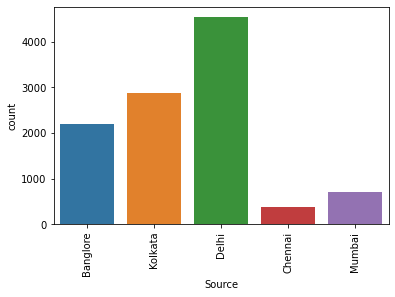

In [ ]:
#Count plot for the Source
sns.countplot(train['Source'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
#Encoding for both train and test data
le = LabelEncoder()
le.fit(train['Source'])
train['Source'] = le.transform(train['Source'])
test['Source'] = le.transform(test['Source'])

The next column we see is the Destination

In [ ]:
#Checking for unique values
train['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

From the code for the cities, we can make out that New Delhi and Delhi are the same. Hence, we shall convert one to form a combined variable.

In [ ]:
#Replacing the data names
train['Destination'].replace({'New Delhi':'Delhi'},inplace=True)
test['Destination'].replace({'New Delhi':'Delhi'},inplace=True)

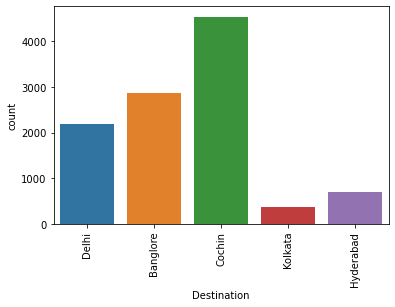

In [ ]:
#Count plot for the Destination
sns.countplot(train['Destination'])
plt.xticks(rotation=90)
plt.show()

We shall encode this data to form a numerical value

In [ ]:
#Encoding for both train and test data
le = LabelEncoder()
le.fit(train['Destination'])
train['Destination'] = le.transform(train['Destination'])
test['Destination'] = le.transform(test['Destination'])

The next column we have is the Route, however we see that the only information we receive with the ccolumn is the number of stops the flight takes. This information we already have in teh dataset through the column Total_Stops and hence we shall drop this column

In [ ]:
#Dropping the column
train.drop(columns='Route', inplace=True)
test.drop(columns='Route', inplace=True)

Next column we see is the Dep_Time, which is a time format and hence we shall convert it into hour and minutes

In [ ]:
#Converting train data
train["Dep_hour"] = pd.to_datetime(train["Dep_Time"]).dt.hour
train["Dep_min"] = pd.to_datetime(train["Dep_Time"]).dt.minute
train.drop(["Dep_Time"], axis = 1, inplace = True)

#Converting test data
test["Dep_hour"] = pd.to_datetime(test["Dep_Time"]).dt.hour
test["Dep_min"] = pd.to_datetime(test["Dep_Time"]).dt.minute
test.drop(["Dep_Time"], axis = 1, inplace = True)

Next column we see is the Arrival_Time, which is a time format and hence we shall convert it into hour and minutes

In [ ]:
#Converting train data
train["Arr_hour"] = pd.to_datetime(train["Arrival_Time"]).dt.hour
train["Arr_min"] = pd.to_datetime(train["Arrival_Time"]).dt.minute
train.drop(["Arrival_Time"], axis = 1, inplace = True)

#Converting test data
test["Arr_hour"] = pd.to_datetime(test["Arrival_Time"]).dt.hour
test["Arr_min"] = pd.to_datetime(test["Arrival_Time"]).dt.minute
test.drop(["Arrival_Time"], axis = 1, inplace = True)

Next column we see is the Duration, which is a time format and hence we shall convert it into hour and minutes

In [ ]:
#Function to split the hour and minutes
def duration(x):
    x = x.split(' ')
    h = 0
    m = 0
    if len(x)==1:
        x = x[0]
        if x[-1]=='h':
            h = int(x[:-1])
        else:
            m = int(x[:-1])
    else:
        h = int(x[0][:-1])
        m = int(x[1][:-1])
    return h, m

#Splitting for train data
train['Dur_hours'] = train['Duration'].apply(lambda x:duration(x)[0])
train['Dur_mins'] = train['Duration'].apply(lambda x:duration(x)[1])
train.drop(["Duration"], axis = 1, inplace = True)

#Splitting for test data
test['Dur_hours'] = test['Duration'].apply(lambda x:duration(x)[0])
test['Dur_mins'] = test['Duration'].apply(lambda x:duration(x)[1])
test.drop(["Duration"], axis = 1, inplace = True)

Next column we see is the Total_Stops

In [ ]:
#Checking for unique values
train['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

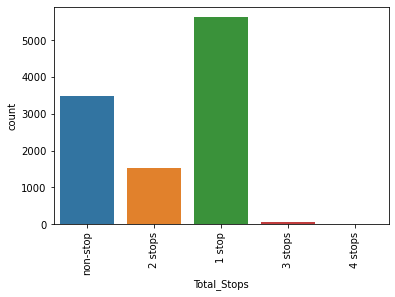

In [ ]:
#Count plot for the Total_Stops
sns.countplot(train['Total_Stops'])
plt.xticks(rotation=90)
plt.show()

Encoding the data

In [ ]:
#Encoding for both train and test data
le = LabelEncoder()
le.fit(train['Total_Stops'])
train['Total_Stops'] = le.transform(train['Total_Stops'])
test['Total_Stops'] = le.transform(test['Total_Stops'])

Next column we see is the Additional_Info

In [ ]:
#Checking for unique values
train['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

We see 'no info' is repeated and hence we shall join the both

In [ ]:
train['Additional_Info'].replace({'No info':'No Info'}, inplace=True)
test['Additional_Info'].replace({'No info':'No Info'}, inplace=True)

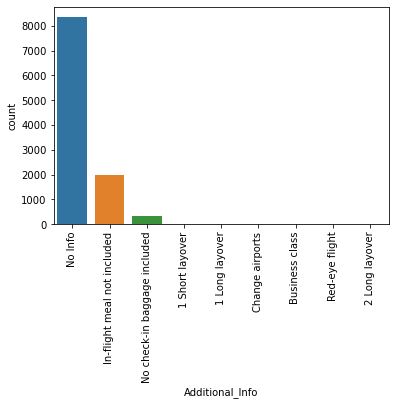

In [ ]:
#Count plot for the Additional_Info
sns.countplot(train['Additional_Info'])
plt.xticks(rotation=90)
plt.show()

Encoding the data

In [ ]:
#Encoding for both train and test data
le = LabelEncoder()
le.fit(train['Additional_Info'])
train['Additional_Info'] = le.transform(train['Additional_Info'])
test['Additional_Info'] = le.transform(test['Additional_Info'])

# Correlation

Now, since all the data has been transformed into numeric values. Let us check for the correlation to the target column

In [ ]:
train.corr() #Correlation matrix

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Day,Month,Dep_hour,Dep_min,Arr_hour,Arr_min,Dur_hours,Dur_mins
Airline,1.000000,-0.013397,0.070532,0.035973,0.090588,-0.039565,0.031118,-0.007900,-0.035269,-0.059922,-0.007567,-0.071092,-0.158136,-0.028009
Source,-0.013397,1.000000,-0.434227,-0.225605,0.008036,0.015999,0.007563,0.063052,0.059047,-0.056998,0.025635,0.021040,0.166121,-0.145193
Destination,0.070532,-0.434227,1.000000,0.510204,0.093787,-0.262164,0.006359,-0.068900,-0.087777,0.096722,-0.058149,0.007259,-0.379670,0.022403
Total_Stops,0.035973,-0.225605,0.510204,1.000000,0.242029,-0.571221,0.043844,-0.056514,0.039224,0.048901,-0.095650,0.175980,-0.606137,0.182223
Additional_Info,0.090588,0.008036,0.093787,0.242029,1.000000,-0.191643,0.017554,-0.000164,-0.043020,0.001673,-0.019455,0.028698,-0.218023,0.054365
Price,-0.039565,0.015999,-0.262164,-0.571221,-0.191643,1.000000,-0.165448,0.010705,0.006799,-0.024458,0.024244,-0.086155,0.508778,-0.124855
Day,0.031118,0.007563,0.006359,0.043844,0.017554,-0.165448,1.000000,-0.264896,-0.002301,-0.016433,-0.002176,-0.021423,-0.037964,-0.007708
Month,-0.007900,0.063052,-0.068900,-0.056514,-0.000164,0.010705,-0.264896,1.000000,0.028189,0.002136,-0.004329,-0.025786,0.055552,-0.018597
Dep_hour,-0.035269,0.059047,-0.087777,0.039224,-0.043020,0.006799,-0.002301,0.028189,1.000000,-0.024745,0.005180,0.067911,0.002869,-0.023707
Dep_min,-0.059922,-0.056998,0.096722,0.048901,0.001673,-0.024458,-0.016433,0.002136,-0.024745,1.000000,0.043122,-0.017597,-0.022104,0.092485


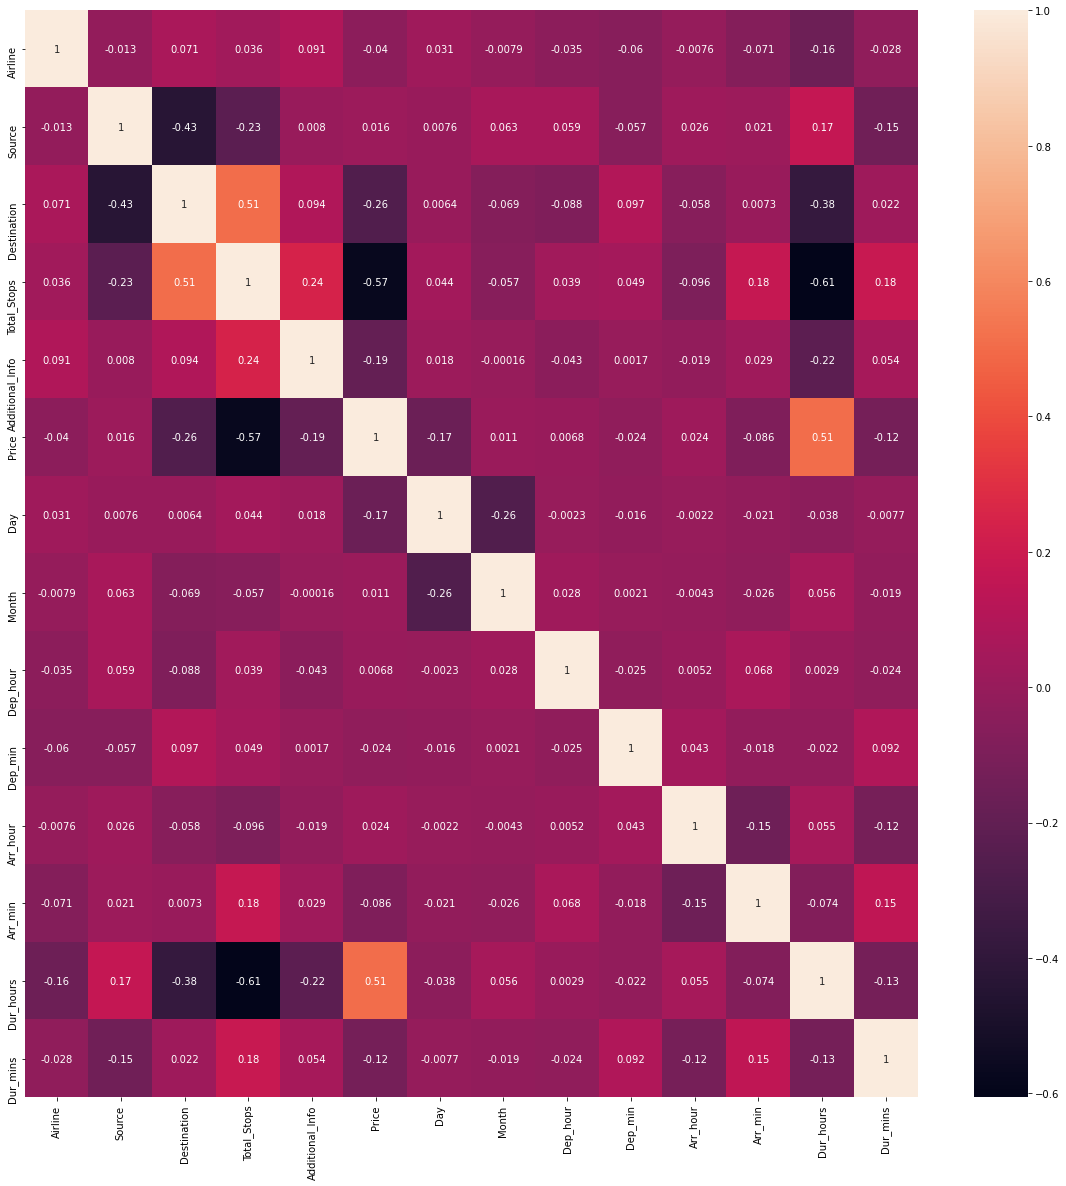

In [ ]:
#Visualization for correlation matrix
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(),annot=True)
plt.show()

In [ ]:
#Correlation wrt target column
train.corr()['Price'].sort_values()

Total_Stops       -0.571221
Destination       -0.262164
Additional_Info   -0.191643
Day               -0.165448
Dur_mins          -0.124855
Arr_min           -0.086155
Airline           -0.039565
Dep_min           -0.024458
Dep_hour           0.006799
Month              0.010705
Source             0.015999
Arr_hour           0.024244
Dur_hours          0.508778
Price              1.000000
Name: Price, dtype: float64

# Outliers

We use the zscore method to remove the outliers with a threshold of 3

In [ ]:
z = np.abs(zscore(train))
df_new = train[(z<3).all(axis=1)]

In [ ]:
df_new.shape

(10505, 14)

In [ ]:
print('Percentage loss of data =\t', ((train.shape[0]-df_new.shape[0])/train.shape[0])*100, '%')

Percentage loss of data =	 1.656993072458341 %


# Skewness

Now, we split the data into feature and target columns.

In [ ]:
x = df_new.drop(columns='Price')
y = df_new['Price']

Checking for skewness

In [ ]:
x.skew()

Airline            0.729360
Source            -0.439575
Destination        0.862979
Total_Stops        0.613819
Additional_Info   -0.728963
Day                0.352984
Month              0.635419
Dep_hour           0.103334
Dep_min            0.171730
Arr_hour          -0.362026
Arr_min            0.107227
Dur_hours          0.765817
Dur_mins          -0.097848
dtype: float64

In [ ]:
#Using sqrt method to treat skewness
for i in x.columns:
    x[i] = np.sqrt(x[i])

In [ ]:
x.skew()

Airline           -0.482326
Source            -1.147730
Destination       -0.354384
Total_Stops        0.390434
Additional_Info   -0.856543
Day                0.175296
Month             -0.064647
Dep_hour          -0.407874
Dep_min           -0.544943
Arr_hour          -1.096490
Arr_min           -0.805762
Dur_hours          0.263097
Dur_mins          -1.006986
dtype: float64

# Scaling the data for model

In [ ]:
sc=StandardScaler()
x = sc.fit_transform(x)

# Random State

In [ ]:
maxRS = 0
maxAcc = 0
for i in range(0,100):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=i)
    lr = LinearRegression()
    lr.fit(x_train,y_train)
    pred = lr.predict(x_test)
    acc = r2_score(y_test, pred)
    if acc>maxAcc:
        maxAcc = acc
        maxRS = i
print("Max accuracy: \t", maxAcc)
print("Random State: \t", maxRS)

Max accuracy: 	 0.5057529625115458
Random State: 	 65


Now since we got the best random state for data modelling, we create the test train models

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=maxRS)

# Model Predictions

Linear Regression

In [ ]:
lr = LinearRegression()
lr.fit(x_train,y_train)
pred = lr.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 50.575296251154576
Mean Square Error : 	 8213354.1602991605
Root Mean Square Error : 	 2865.8950016180215


Ridge Regression

In [ ]:
rr = Ridge()
rr.fit(x_train,y_train)
pred = rr.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 50.57498077703786
Mean Square Error : 	 8213406.585512718
Root Mean Square Error : 	 2865.9041479981006


KNN Regressor

In [ ]:
knn = KNeighborsRegressor()
knn.fit(x_train,y_train)
pred = knn.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 78.27521048487847
Mean Square Error : 	 3610206.5730604474
Root Mean Square Error : 	 1900.0543605540468


SUPPORT VECTOR MACHINES

In [ ]:
svr = SVR()
svr.fit(x_train,y_train)
pred = svr.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 6.299731965428823
Mean Square Error : 	 15571028.815744182
Root Mean Square Error : 	 3946.014294923953


Random Forest Regressor

In [ ]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 91.92432399286952
Mean Square Error : 	 1342008.7951855992
Root Mean Square Error : 	 1158.4510327094536


Decision Tree Regressor

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)
pred = dt.predict(x_test)
print("r2 score: \t", r2_score(y_test,pred)*100)
print("Mean Square Error : \t", mean_squared_error(y_test,pred))
print("Root Mean Square Error : \t", np.sqrt(mean_squared_error(y_test,pred)))

r2 score: 	 85.2462067779275
Mean Square Error : 	 2451772.489249035
Root Mean Square Error : 	 1565.8136828017039


Out of all the models Random Forest Regressor and the Decision Tree Regressor has the highest r2_score

# Cross validation

In [ ]:
scr1 = cross_val_score(lr, x, y, cv=5, scoring='r2')
print("Cross validation score of Linear Regression is: \t", scr1.mean())

Cross validation score of Linear Regression is: 	 0.46847722633285843


In [ ]:
scr2 = cross_val_score(rr, x, y, cv=5, scoring='r2')
print("Cross validation score of Ridge Regression is: \t", scr2.mean())

Cross validation score of Ridge Regression is: 	 0.4684775338492031


In [ ]:
scr3 = cross_val_score(dt, x, y, cv=5)
print("Cross validation score of Decision Tree Regressor is: \t", scr3.mean())

Cross validation score of Decision Tree Regressor is: 	 0.8639861957876975


In [ ]:
scr4 = cross_val_score(rf, x, y, cv=5)
print("Cross validation score of Random Forest Regressor is: \t", scr4.mean())

Cross validation score of Random Forest Regressor is: 	 0.9200102312815931


In [ ]:
scr5 = cross_val_score(knn, x, y, cv=5)
print("Cross validation score of KNeighbour Regressor is: \t", scr5.mean())

Cross validation score of KNeighbour Regressor is: 	 0.7690662968604609


In [ ]:
scr6 = cross_val_score(svr, x, y, cv=5)
print("Cross validation score of SVM is: \t", scr6.mean())

Cross validation score of SVM is: 	 0.053189734800247426


We see that the Random Forest Regressor performs the best in cross validation

# Hyper Parameter Tuning

In [ ]:
GridSearchCV.get_params(rf)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
parameters = {'bootstrap': [True,False],
              'max_depth': [10, 20, None],
              'min_samples_leaf': [1,2,4],
              'min_samples_split': [2,5,10],
              'n_estimators': [100,200]}

In [ ]:
gcv = GridSearchCV(rf, parameters, cv=5, scoring='r2')

In [ ]:
gcv.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             scoring='r2')

In [ ]:
print("Tuned Hyperparameters :", gcv.best_params_)
print("Accuracy :",gcv.best_score_)

Tuned Hyperparameters : {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy : 0.9119113891471426


In [ ]:
gcv_pred = gcv.best_estimator_.predict(x_test)
r2_score(y_test,gcv_pred)

0.9226586536939119

The best estimator gives the accuracy of 92.26% and hence we shall save this model.

# Saving the best model

In [ ]:
joblib.dump(gcv.best_estimator_,"flight_price.pkl")

['flight_price.pkl']